<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF/blob/main/VCA_FCLSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Unmixing - VCA+FCLSU

Supervised unmixing baseline using VCA for endmembers extraction and FCLSU for abundances estimation.

---

## Imports

1. Clone tutorial repository.
2. Install required Python packages.
3. Import Python packages.

In [1]:
!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git

Cloning into 'Unmixing_Tutorial_IEEE_IADF'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 251 (delta 3), reused 3 (delta 3), pack-reused 243
Receiving objects: 100% (251/251), 58.78 MiB | 23.11 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [4]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import time
import os

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
from cvxopt import matrix, solvers

from munkres import Munkres

In [6]:
from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SAD
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SRE
from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner
from Unmixing_Tutorial_IEEE_IADF.utils.noises import AdditiveWhiteGaussianNoise as AWGN

## Data

---

Create a HSI data object.

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'])
HSI => Sim1
---------------------
224 bands,
105 lines, 105 samples, (11025 pixels),
6 endmembers (['#0', '#1', '#2', '#3', '#4', '#5'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0



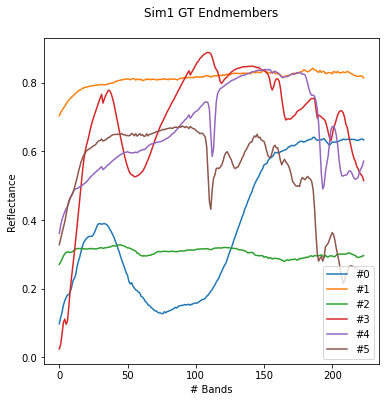

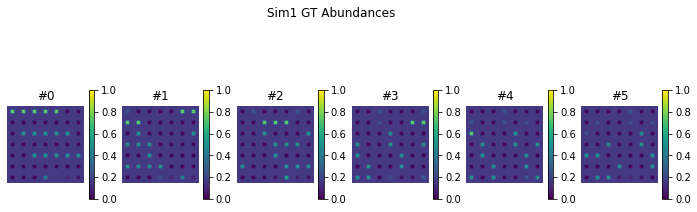

In [7]:
hsi = HSI("Sim1.mat")
print(hsi)
hsi.plot_endmembers()
hsi.plot_abundances()

## Endmembers extraction

---

The following code provides several endmembers initialization methods including `VCA`.

In [8]:
class BaseInit:
    def __init__(self):
        self.seed = None

    def init_like(self, hsi, seed=0):
        return NotImplementedError

    def __repr__(self):
        msg = f"{self.__class__.__name__}_seed{self.seed}"
        return msg


class TrueEndmembers(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, **kwargs):
        return hsi.E


class RandomPositiveMatrix(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, seed=0):
        self.seed = seed
        generator = np.random.RandomState(seed=self.seed)
        return generator.rand(hsi.L, hsi.p)


class RandomPixels(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, seed=0):
        self.seed = seed
        generator = np.random.RandomState(seed=self.seed)
        indices = generator.randint(0, high=hsi.N - 1, size=hsi.p)
        print(f"Indices randomly chosen: {indices}")
        pixels = hsi.Y[:, indices]
        assert pixels.shape == hsi.E.shape
        return pixels


class VCA(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, seed=0, snr_input=0):
        """
        Vertex Component Analysis
        ------- Input variables -------------
        HSI containing the following variables =>
         Y - matrix with dimensions L(channels) x N(pixels)
             each pixel is a linear mixture of R endmembers
             signatures Y = M x s, where s = gamma x alfa
             gamma is a illumination perturbation factor and
             alfa are the abundance fractions of each endmember.
         p - positive integer number of endmembers in the scene
        ------- Output variables -----------
        E     - estimated mixing matrix (endmembers signatures)
        ------- Optional parameters---------
        snr_input - (float) signal to noise ratio (dB)
        ------------------------------------
        Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
        This code is a translation of a matlab code provided by
        Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
        available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
        Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
        more details on:
        Jose M. P. Nascimento and Jose M. B. Dias
        "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
        submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
        """
        Y = hsi.Y
        N, p = hsi.N, hsi.p
        self.seed = seed
        generator = np.random.RandomState(seed=seed)

        #############################################
        # SNR Estimates
        #############################################

        if snr_input == 0:
            y_m = np.mean(Y, axis=1, keepdims=True)
            Y_o = Y - y_m  # data with zero-mean
            Ud = LA.svd(np.dot(Y_o, Y_o.T) / float(N))[0][
                :, :p
            ]  # computes the R-projection matrix
            x_p = np.dot(Ud.T, Y_o)  # project the zero-mean data onto p-subspace

            SNR = self.estimate_snr(Y, y_m, x_p)

            print(f"SNR estimated = {SNR:.2f}[dB]")
        else:
            SNR = snr_input
            print(f"input SNR = {SNR:.2f}[dB]\n")

        SNR_th = 15 + 10 * np.log10(p)
        #############################################
        # Choosing Projective Projection or
        #          projection to p-1 subspace
        #############################################

        if SNR < SNR_th:
            print("... Select proj. to R-1")

            d = p - 1
            if snr_input == 0:  # it means that the projection is already computed
                Ud = Ud[:, :d]
            else:
                y_m = np.mean(Y, axis=1, keepdims=True)
                Y_o = Y - y_m  # data with zero-mean

                Ud = LA.svd(np.dot(Y_o, Y_o.T) / float(N))[0][
                    :, :d
                ]  # computes the p-projection matrix
                x_p = np.dot(Ud.T, Y_o)  # project thezeros mean data onto p-subspace

            Yp = np.dot(Ud, x_p[:d, :]) + y_m  # again in dimension L

            x = x_p[:d, :]  #  x_p =  Ud.T * Y_o is on a R-dim subspace
            c = np.amax(np.sum(x ** 2, axis=0)) ** 0.5
            y = np.vstack((x, c * np.ones((1, N))))
        else:
            print("... Select the projective proj.")

            d = p
            Ud = LA.svd(np.dot(Y, Y.T) / float(N))[0][
                :, :d
            ]  # computes the p-projection matrix

            x_p = np.dot(Ud.T, Y)
            Yp = np.dot(
                Ud, x_p[:d, :]
            )  # again in dimension L (note that x_p has no null mean)

            x = np.dot(Ud.T, Y)
            u = np.mean(x, axis=1, keepdims=True)  # equivalent to  u = Ud.T * r_m
            y = x / np.dot(u.T, x)

        #############################################
        # VCA algorithm
        #############################################

        indices = np.zeros((p), dtype=int)
        A = np.zeros((p, p))
        A[-1, 0] = 1

        for i in range(p):
            w = generator.rand(p, 1)
            f = w - np.dot(A, np.dot(LA.pinv(A), w))
            f = f / np.linalg.norm(f)

            v = np.dot(f.T, y)

            indices[i] = np.argmax(np.absolute(v))
            A[:, i] = y[:, indices[i]]  # same as x(:,indice(i))

        E = Yp[:, indices]

        print(f"Indices chosen to be the most pure: {indices}")
        self.indices = indices

        return E

    @staticmethod
    def estimate_snr(Y, r_m, x):
        L, N = Y.shape  # L number of bands (channels), N number of pixels
        p, N = x.shape  # p number of endmembers (reduced dimension)

        P_y = np.sum(Y ** 2) / float(N)
        P_x = np.sum(x ** 2) / float(N) + np.sum(r_m ** 2)
        snr_est = 10 * np.log10((P_x - p / L * P_y) / (P_y - P_x))

        return snr_est

## Abundances estimation

---

The following code provides the `FCLSU` method implementation for abundances estimation given a set of endmembers (supervised unmixing).

In [9]:
class FCLSU:
    def __init__(self):
        pass

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

    @staticmethod
    def _numpy_None_vstack(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.vstack([A1, A2])

    @staticmethod
    def _numpy_None_concatenate(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.concatenate([A1, A2])

    @staticmethod
    def _numpy_to_cvxopt_matrix(A):
        A = np.array(A, dtype=np.float64)
        if A.ndim == 1:
            return matrix(A, (A.shape[0], 1), "d")
        else:
            return matrix(A, A.shape, "d")

    def solve(self, Y, E):
        """
        Performs fully constrained least squares of each pixel in M
        using the endmember signatures of U. Fully constrained least squares
        is least squares with the abundance sum-to-one constraint (ASC) and the
        abundance nonnegative constraint (ANC).
        Parameters:
            Y: `numpy array`
                2D data matrix (L x N).
            E: `numpy array`
                2D matrix of endmembers (L x p).
        Returns:
            X: `numpy array`
                2D abundance maps (p x N).
        References:
            Daniel Heinz, Chein-I Chang, and Mark L.G. Fully Constrained
            Least-Squares Based Linear Unmixing. Althouse. IEEE. 1999.
        Notes:
            Three sources have been useful to build the algorithm:
                * The function hyperFclsMatlab, part of the Matlab Hyperspectral
                Toolbox of Isaac Gerg.
                * The Matlab (tm) help on lsqlin.
                * And the Python implementation of lsqlin by Valera Vishnevskiy, click:
                http://maggotroot.blogspot.ca/2013/11/constrained-linear-least-squares-in.html
                , it's great code.
        """
        tic = time.time()
        assert len(Y.shape) == 2
        assert len(E.shape) == 2

        L1, N = Y.shape
        L2, p = E.shape

        assert L1 == L2

        # Reshape to match implementation
        M = np.copy(Y.T)
        U = np.copy(E.T)

        solvers.options["show_progress"] = False

        U = U.astype(np.double)

        C = self._numpy_to_cvxopt_matrix(U.T)
        Q = C.T * C

        lb_A = -np.eye(p)
        lb = np.repeat(0, p)
        A = self._numpy_None_vstack(None, lb_A)
        b = self._numpy_None_concatenate(None, -lb)
        A = self._numpy_to_cvxopt_matrix(A)
        b = self._numpy_to_cvxopt_matrix(b)

        Aeq = self._numpy_to_cvxopt_matrix(np.ones((1, p)))
        beq = self._numpy_to_cvxopt_matrix(np.ones(1))

        M = np.array(M, dtype=np.float64)
        M = M.astype(np.double)
        X = np.zeros((N, p), dtype=np.float32)
        for n1 in range(N):
            d = matrix(M[n1], (L1, 1), "d")
            q = -d.T * C
            sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, None)["x"]
            X[n1] = np.array(sol).squeeze()
        tac = time.time()
        print(f"{self} took {tac - tic:.2f}s")
        return X.T

## Main pipeline

---

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'])
Y shape: (224, 11025)
Desired SNR: 40
Sigmas after normalization: 0.0668153104781061
Sigma mean based on SNR: 0.09648830104929844
Final sigmas value: 0.006446895792113846
input SNR = 40.00[dB]

... Select the projective proj.
Indices chosen to be the most pure: [5647  982 8780 3920  921 3787]
FCLSU took 10.54s


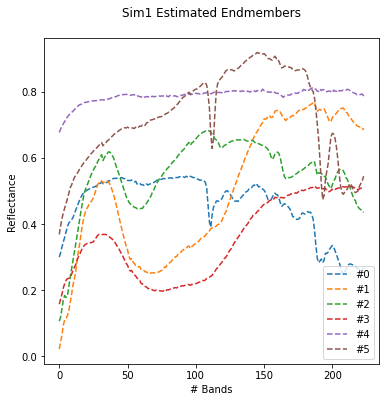

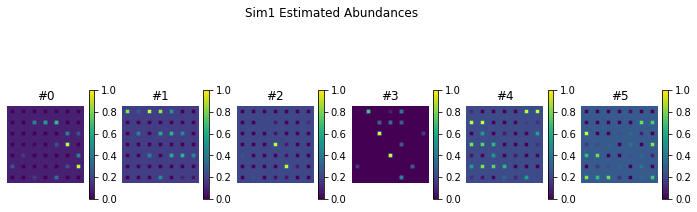

In [17]:
# Instantiate objects
extractor = VCA()
#extractor = TrueEndmembers()
#extractor = RandomPixels()
model = FCLSU()
hsi = HSI("Sim1.mat")

noise = AWGN()

SNR = 40

hsi.Y = noise.fit_transform(hsi.Y, SNR=SNR, seed=0)

# Endmembers extraction
E0 = extractor.init_like(hsi, seed=0, snr_input=SNR)

# Call data to return HSI
Y, _, _ = hsi()

# Abundances estimation
A0 = model.solve(Y, E0)

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

## Endmembers alignment

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.

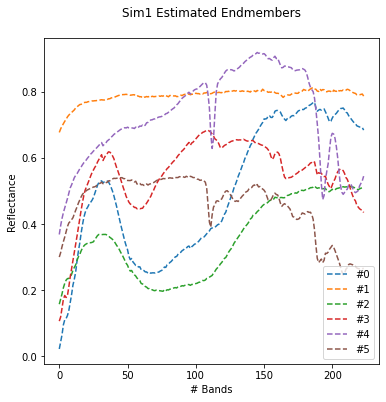

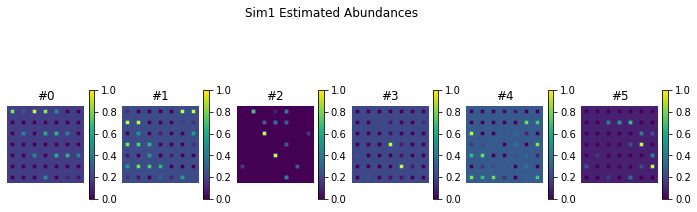

In [18]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

Notice how the materials were swapped.

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [19]:
# Instantiate metrics
rmse = RMSE()
sad = SAD()
sre = SRE()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")
print(f"SRE => {sre(A1, hsi.A):.2f}")

RMSE => 11.56
SAD => 6.17
SRE => 4.10


### Results for each material

In [ ]:
# Change the following line if you change dataset!
# Either comment out or describe each material name.
#hsi.labels = ["Road", "Tree", "Roof", "Water"]
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")

RMSE (#0) => 3.50
RMSE (#1) => 4.56
RMSE (#2) => 3.08
RMSE (#3) => 3.58
RMSE (#4) => 3.38
RMSE (#5) => 5.87
RMSE (#6) => 6.18
RMSE (#7) => 3.46
RMSE (#8) => 3.27
---------------
SAD (#0) => 0.59
SAD (#1) => 0.16
SAD (#2) => 0.14
SAD (#3) => 0.36
SAD (#4) => 0.41
SAD (#5) => 0.88
SAD (#6) => 0.72
SAD (#7) => 0.05
SAD (#8) => 0.38
